<a href="https://colab.research.google.com/github/askolesov0608/CV_NV/blob/main/99CVLab6_Part2ADD_Tests.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load and setup

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
from google.colab import files

In [3]:
!cp /content/gdrive/MyDrive/CV/Lab6/visualPercepUtils.py /content #copy file

In [4]:
#!cp -r /content/gdrive/MyDrive/CV/Lab6/ /content #copy all folder

In [5]:
import os
import time

source_dir = '/content/gdrive/MyDrive/CV/Lab6/'
destination_dir = '/content/Lab6/'

# Функция для копирования файлов или папок
def copy_files(source_dir, destination_dir):
    os.system(f"cp -r {source_dir} {destination_dir}")

# Проверка наличия папки Lab6 в папке content
def check_copy_completion(destination_dir):
    return os.path.exists(destination_dir)

# Копирование файлов или папок
copy_files(source_dir, destination_dir)

# Проверка завершения копирования и повторение через время, если необходимо
while not check_copy_completion(destination_dir):
    print("Копирование не завершено, повтор через 60 секунд...")
    time.sleep(60)  # Повтор через 60 секунд
    copy_files(source_dir, destination_dir)

print("Копирование завершено.")

Копирование завершено.


In [6]:
import numpy as np
from scipy import signal

from skimage.data import stereo_motorcycle, moon, astronaut, camera
from skimage.transform import SimilarityTransform, warp

from skimage.color import rgb2gray
import matplotlib.pylab as plt
from skimage.filters import gaussian
#from skimage.registration import optical_flow_ilk as LK
from mpl_toolkits.axes_grid1 import ImageGrid
from PIL import Image
from skimage.transform import rescale

import cv2
from scipy import ndimage as ndi
from copy import deepcopy

import glob # Модуль для поиска файлов в директориях с помощью шаблонов в Unix стиле. Например, glob.glob('*.png')
import visualPercepUtils as vpu






In [8]:
folder_path = './Lab6/imgs-P6/taxi'

# Получаем список всех файлов в папке
all_files = os.listdir(folder_path)

# Фильтруем только файлы изображений (например, с расширениями .png, .jpg и т. д.)
image_files = [file for file in all_files if file.endswith(('.png', '.jpg', '.jpeg',".png"))]

# Открываем все изображения и сохраняем их в словарь
images = {}
for filename in image_files:
    path_input = os.path.join(folder_path, filename)
    images[filename] = Image.open(path_input)

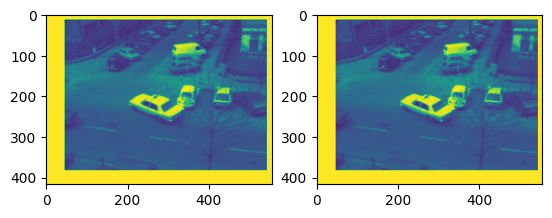

In [9]:
I1 = images['taxi_frame000.png']
I2 = images['taxi_frame001.png']
fig, ax = plt.subplots(1, 2)
ax[0].imshow(I1)
ax[1].imshow(I1)
plt.show()

# 4. Additional and optional activities

####  Compute the Gaussian pyramid of the input images

In [10]:
import cv2
import numpy as np
I1 = images['taxi_frame000.png']
I2 = images['taxi_frame001.png']
I1 = np.array(I1)
I2 = np.array(I2)

In [20]:
def optical_flow(I1, I2, window_size=3, tau=0.01, bDisplay=False):

    kernel_x = np.array([[-1., 1.], [-1., 1.]])

  #Your code (1): kernels for y
    kernel_y = kernel_x.T # Transpouse for Vertical

  #Your code (1): kernels for t
    kernel_size = 4
    kernel_t = np.ones((kernel_size, kernel_size), dtype=np.float32) / (kernel_size**2)

    w = int(window_size/2) # window_size is odd, all the pixels with offset in between [-w, w] are inside the window

    I1g = gaussian(I1, sigma=5, truncate=1/5)
    I2g = gaussian(I2, sigma=5, truncate=1/5)

    # Implement Lucas-Kanade
    # for each image point, calculate I_x, I_y, I_t
    mode = 'same'
    fx = signal.convolve2d(I1g, kernel_x, boundary='symm', mode=mode)

 #fy = # your code (1)
    fy = signal.convolve2d(I1, kernel_y, mode='same', boundary='symm')

 #ft = # your code (1)
    ft1 = signal.convolve2d(I1g, kernel_t, boundary='symm', mode=mode)
    ft2 = signal.convolve2d(I2g, kernel_t, boundary='symm', mode=mode)
    ft = ft1 - ft2


    if bDisplay:
        for f in [fx,fy,ft]:
            plt.imshow(f,cmap='gray')
            plt.show(block=True)

    u = np.zeros(I1g.shape)
    v = np.zeros(I1g.shape)

    # iterate for each image window of size window_size * window_size
    M,N = I1g.shape
    for i in range(w, M-w):
        for j in range(w, N-w): #Создаем массив части изображения
            Ix = fx[i-w:i+w+1, j-w:j+w+1].flatten() # fx нашли вертикаль через конв с ядром [-1., 1.], [-1., 1.]
            Iy = fy[i-w:i+w+1, j-w:j+w+1].flatten() # fy нашли горизонталь [-1., -1.], [1., 1.]
            It = ft[i-w:i+w+1, j-w:j+w+1].flatten() # ft  просто усреднили изображение по среднему фильтру 4х4

            #AtA = # your code (2)  #A = np.vstack((Ix, Iy)) -- A=A.T
            A = np.vstack((Ix, Iy)).T
            AtA = np.dot(A.T, A)

             #Atb = # your code (2)
            b = -It.reshape(-1, 1)   # В одинстолбец [Ix, Iy][u / V] = -It так как их тейлора вывели что все производные можно уюрать оставив только I(x,y,t)
            Atb = np.dot(A.T, b)


             # your code (4)
             #if # your code (4)

            if np.linalg.matrix_rank(AtA) == 2 and np.min(np.linalg.eigvals(AtA)) > tau:
               nu, residuals, rank, s = np.linalg.lstsq(AtA, Atb, rcond=None)
               u[i, j] = nu[0, 0]  # Извлекаем первый элемент из первой строки
               v[i, j] = nu[1, 0]  # Извлекаем второй элемент из первой строки, если он есть
               #print(f"  Optical flow components - u: {u[i,j]}, v: {v[i,j]}")
            else:
                u[i, j] = 0
                v[i, j] = 0

    return u,v

In [21]:

def Gause_scale_images_and_run(I1_original, I2_original, tau):
    levels = 4  # Количество уровней Гауссовской пирамиды

    # Создание пирамиды масштабирования для каждого изображения
    I1_pyramid = [I1_original]
    I2_pyramid = [I2_original]
    for i in range(1, levels):
        I1_pyramid.append(cv2.pyrDown(I1_pyramid[i - 1]))
        I2_pyramid.append(cv2.pyrDown(I2_pyramid[i - 1]))

    for level in range(levels):
        I1_scaled = I1_pyramid[level]
        I2_scaled = I2_pyramid[level]

        # Запуск экспериментов с оптическим потоком
        print(f"Running experiments for pyramid level {level + 1} with scale factor {0.5 ** level}")
        run_experiments_and_plot_NoHist(I1_scaled, I2_scaled, tau)

In [22]:
def display_quiver_plot(I1, u, v, step=10, title='Optical Flow Vectors'):
    """
    Displays a quiver plot for the optical flow vectors on top of the image.

    Parameters:
        I1 (numpy.ndarray): The first image frame (grayscale).
        u (numpy.ndarray): The horizontal components of the optical flow vectors.
        v (numpy.ndarray): The vertical components of the optical flow vectors.
        step (int): The grid step size for displaying vectors (default: 10 pixels).
        title (str): The title of the plot.
    """
    # Normalize the flow vectors for better visualization
    magnitude = np.sqrt(u**2 + v**2)
    #norm_u = u / (magnitude + 1e-5)  # Adding a small constant to avoid division by zero
    #norm_v = v / (magnitude + 1e-5)

    norm_u = u
    norm_v = v

    # Set up the quiver plot
    plt.figure(figsize=(8, 8))
    plt.imshow(I1, cmap='gray', interpolation='nearest')
    plt.quiver(np.arange(0, u.shape[1], step), np.arange(0, u.shape[0], step),
               norm_u[::step, ::step], norm_v[::step, ::step], magnitude[::step, ::step],
               scale=50, cmap='jet', headwidth=7)

    plt.title(title)
    plt.axis('off')  # Turn off axis
    plt.colorbar(label='Magnitude of flow')
    plt.show()

In [23]:
def run_experiments_and_plot_NoHist(I1, I2, tau):

    u, v = optical_flow(I1, I2, window_size=window_size, tau=tau)

    # Подготовка сабплота для векторного поля
    display_quiver_plot(I1, u, v, title=f"Optical Flow Vectors Gaussin Piramid")

    plt.tight_layout()
    plt.show()

Running experiments for pyramid level 1 with scale factor 1.0


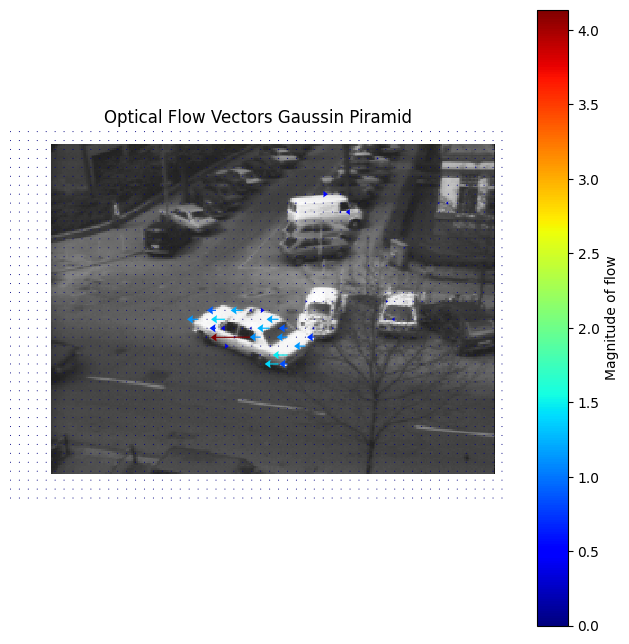

<Figure size 640x480 with 0 Axes>

Running experiments for pyramid level 2 with scale factor 0.5


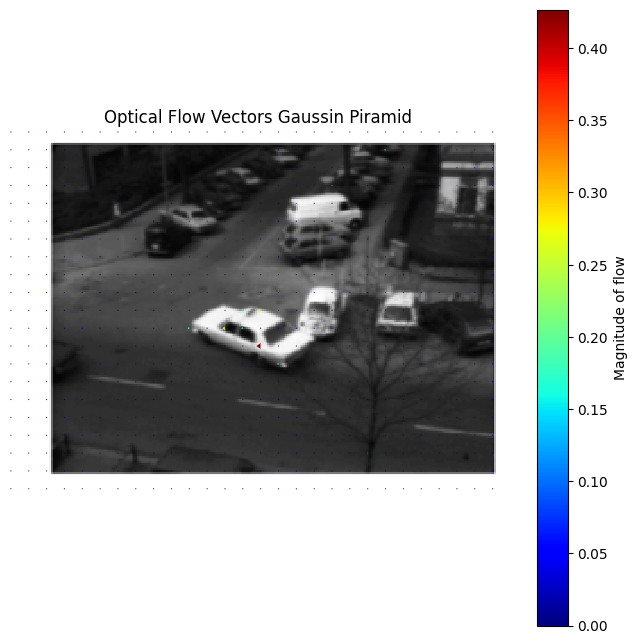

<Figure size 640x480 with 0 Axes>

Running experiments for pyramid level 3 with scale factor 0.25


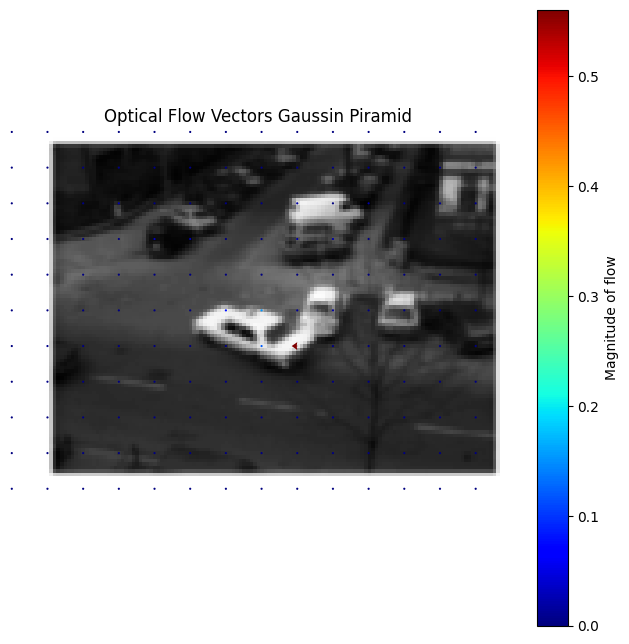

<Figure size 640x480 with 0 Axes>

Running experiments for pyramid level 4 with scale factor 0.125


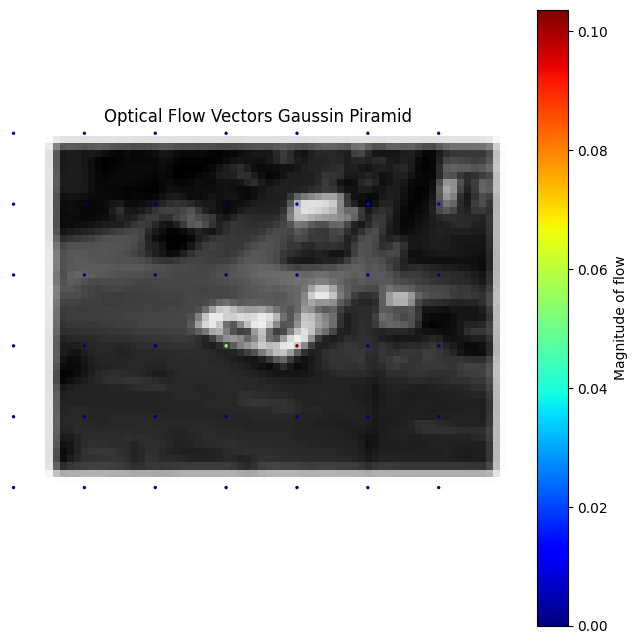

<Figure size 640x480 with 0 Axes>

In [24]:
 #window_size=3
 tau = 0.01
 Gause_scale_images_and_run(I1, I2, tau)

####  Try to approximately segment the object(s) in real sequences

In [25]:
def segment_moving_objects(frame1, frame2):
    # Convert frames to grayscale
    gray1 = frame1
    gray2 = frame2

    #gray1 = cv2.cvtColor(frame1, cv2.COLOR_BGR2GRAY)
    #gray2 = cv2.cvtColor(frame2, cv2.COLOR_BGR2GRAY)

    # Calculate optical flow (Farneback's method)
    flow = cv2.calcOpticalFlowFarneback(gray1, gray2, None, 0.5, 3, 15, 3, 5, 1.2, 0)
    #cv2.calcOpticalFlowFarneback(prev, next, flow, pyr_scale, levels, winsize, iterations, poly_n, poly_sigma, flags)
    #prev: Первый входной массив (предыдущий кадр).
    #next: Второй входной массив (следующий кадр), такого же размера как и prev
    #flow: Выходной массив оптического потока, который будет содержать полученные значения.
    #pyr_scale: Масштабный коэффициент для построения пирамиды изображений. Значение по умолчанию - 0.5.
    #levels: Количество уровней пирамиды, используемых для поиска оптического потока. Значение по умолчанию - 5
    #insize: Размер окна, используемого для вычисления оптического потока. Значение по умолчанию - 13.
    #iterations: Количество итераций, используемых на каждом уровне пирамиды. Значение по умолчанию - 10.
    #poly_n: Размер окна, используемого для поиска оптимального полинома на каждом пикселе. Значение по умолчанию - 5.
    #poly_sigma: Стандартное отклонение Гауссова размытия, применяемого к окну, чтобы найти полиномы на каждом пикселе. Значение по умолчанию - 1.1.
    #flags: Дополнительные флаги, управляющие поведением функции.
    #      Это может быть одно из следующих значений: cv2.OPTFLOW_USE_INITIAL_FLOW, cv2.OPTFLOW_FARNEBACK_GAUSSIAN, cv2.OPTFLOW_FARNEBACK_HAAR

    magnitude, angle = cv2.cartToPolar(flow[..., 0], flow[..., 1])
    #cv2.cartToPolar(x, y, magnitude=None, angle=None, angleInDegrees=False)
    #x: Входной массив с компонентами вектора по оси X.
    #y: Входной массив с компонентами вектора по оси Y. Этот массив должен иметь такие же размеры как и массив x.
    #-magnitude: Выходной массив, который будет содержать значения магнитуды вектора (опциональный).
                #----Если этот аргумент не указан, он будет создан и возвращен.
    #-angle: Выходной массив, который будет содержать значения угла вектора (опциональный).
             #Е-----Eсли этот аргумент не указан, он будет создан и возвращен.
    #angleInDegrees: Логический флаг, указывающий, следует ли
                     #возвращать угол в градусах (True) или радианах (False). Значение по умолчанию - False.


    # Normalize magnitude for better visualization
    norm_mag = cv2.normalize(magnitude, None, 0, 255, cv2.NORM_MINMAX)
    norm_mag = norm_mag.astype(np.uint8)

    # Thresholding the magnitude to segment moving objects
    _, segmented = cv2.threshold(norm_mag, 25, 255, cv2.THRESH_BINARY)  # Adjust the threshold value based on your application
    #cv2.threshold(src, thresh, maxval, type[, dst])
    #src: Входное изображение, которое должно быть одноканальным (монохромным)
    #thresh: Пороговое значение, которое определяет, какие пиксели будут классифицированы как передний или задний план.
    #maxval: Максимальное значение, которое будет присвоено пикселям, превышающим порог. Обычно это 255 для изображений в формате 8 бит
    #type: Тип пороговой операции. Это может быть одно из следующих значений:
           #cv2.THRESH_BINARY: Пиксели, значения которых выше порога, устанавливаются в maxval, а ниже порога - в 0.
           #cv2.THRESH_BINARY_INV: Пиксели, значения которых выше порога, устанавливаются в 0, а ниже порога - в maxval
           #cv2.THRESH_TRUNC: Пиксели, значения которых выше порога, устанавливаются в пороговое значение, а все остальные значения остаются неизменными.
           #cv2.THRESH_TOZERO: Пиксели, значения которых выше порога, остаются неизменными, а все остальные устанавливаются в 0.
           #cv2.THRESH_TOZERO_INV: Пиксели, значения которых выше порога, устанавливаются в 0, а все остальные остаются неизменными.
  #dst (опциональный): Выходное изображение того же размера и типа, что и src, куда будет сохранен результат пороговой обработки.
  #Возвращает
  #-----retval: Значение порога, которое было использовано в операции пороговой обработки.
                #Это обычно значение thresh,
                #но может быть изменено, если был использован метод порогования
                # cv2.THRESH_OTSU или cv2.THRESH_TRIANGLE. В этих случаях retval будет содержать фактическое значение порога, выбранное алгоритмом автоматического выбора порога.
         #dst: Выходное изображение, которое содержит результат пороговой обработки.
         #Это может быть указанный аргумент dst или новое изображение, созданное внутри функции, если dst не был указан.

    # Find connected components
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(segmented, connectivity=8)
    #retval, labels, stats, centroids = cv2.connectedComponentsWithStats(image, connectivity=8, ltype=cv2.CV_32S)
    #image: Входное бинарное изображение
    #connectivity: Опциональный параметр, определяющий тип связности. Это целое число, которое может быть равно 4 или 8. Значение по умолчанию - 8
    #ltype: Тип данных для меток связанных компонентов. Это опциональный параметр, который определяет тип данных,
            #используемый для хранения меток связанных компонентов.
            #Возможные значения: cv2.CV_32S (знаковое 32-битное целое) и cv2.CV_16U (беззнаковое 16-битное целое).
            #Значение по умолчанию - cv2.CV_32S.
   #Возврат
   #retval: Количество обнаруженных связанных компонентов (меток), включая фоновый компонент.
   #labels: Выходное изображение, содержащее метки связанных компонентов. Это массив с размером равным размеру входного изображения  image.
   #stats: Массив статистических характеристик для каждой связанной компоненты.
          #Каждая строка этого массива содержит статистику для соответствующей метки в массиве labels.
          #Статистика включает в себя координаты ограничивающего прямоугольника, его ширину и высоту, а также площадь связанной компоненты.
  #centroids: Координаты центроидов (геометрических центров масс) для каждой связанной компоненты.



    # Optional: Color the connected components for visualization
    output_image = np.zeros_like(frame1)
    for i in range(1, num_labels):  # Start from 1 to ignore the background
        mask = labels == i
        #labels == i True, если значение в labels равно i, и False в противном случае.
        #Значение этого выражения присваивается переменной mask, так что mask теперь содержит булев массив, где True соответствует пикселям с меткой i, а False - всем остальным пикселям.
        output_image[mask] = frame1[mask]

    return output_image, num_labels, labels, stats, centroids

##### Testing Def Function step by step and tune

8.565192


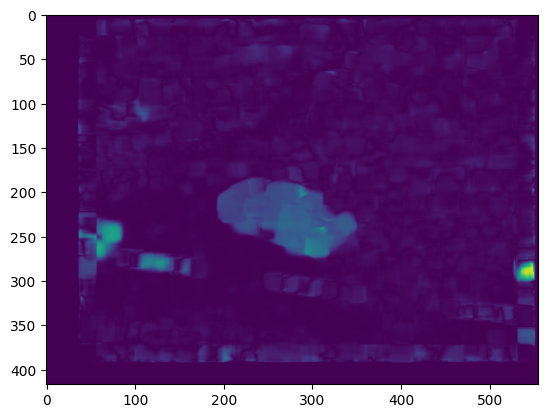

In [26]:
flow = cv2.calcOpticalFlowFarneback(I1, I2, None, 0.5, 3, 15, 3, 5, 1.2, 0)
magnitude, angle = cv2.cartToPolar(flow[..., 0], flow[..., 1])
sd = np.max(magnitude)
print(sd)
plt.imshow(magnitude)

0.0


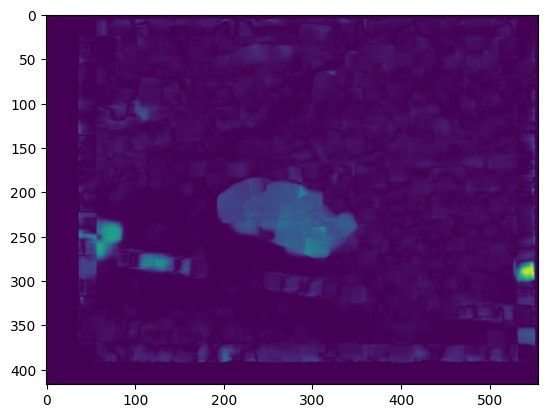

In [27]:
norm_mag = cv2.normalize(magnitude, None, 0, 255, cv2.NORM_MINMAX)
sdm = np.min(norm_mag)
print(sdm)
plt.imshow(norm_mag)

25.0


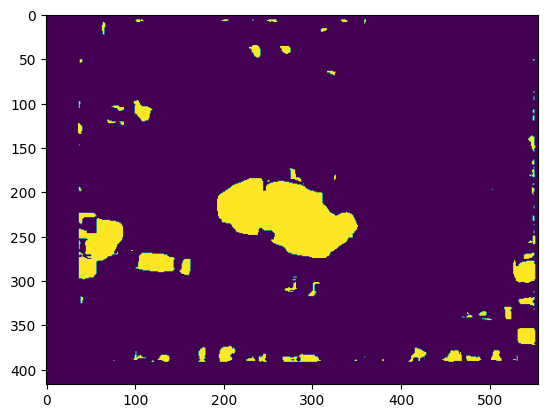

In [28]:
cv, segmented = cv2.threshold(norm_mag, 25, 255, cv2.THRESH_BINARY)
print(cv)
plt.imshow(segmented)

In [29]:
_, segmented = cv2.threshold(norm_mag, 25, 255, cv2.THRESH_BINARY)
segmented = segmented.astype('uint8')

num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(segmented, connectivity=8)

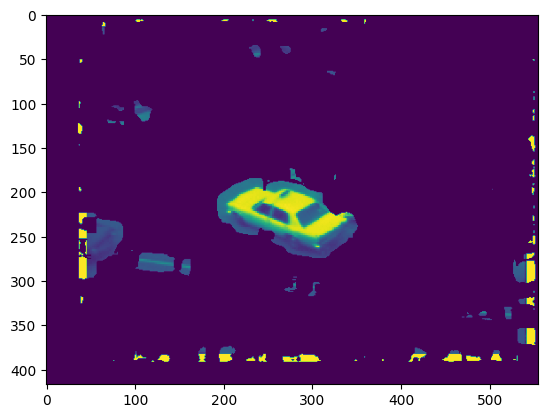

In [30]:
output_image = np.zeros_like(I1)
for i in range(1, num_labels):  # Start from 1 to ignore the background
    mask = labels == i
    #labels == i True, если значение в labels равно i, и False в противном случае.
    #Значение этого выражения присваивается переменной mask, так что mask теперь содержит булев массив, где True соответствует пикселям с меткой i, а False - всем остальным пикселям.
    output_image[mask] = I1[mask]
plt.imshow(output_image)

##### Exe Function

In [31]:
segmented_image, num_labels, labels, stats, centroids = segment_moving_objects(I1, I2)

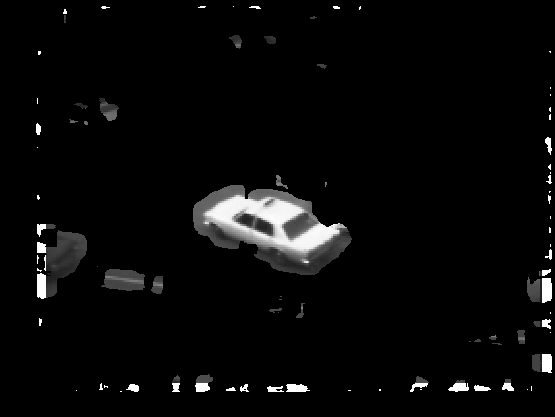

In [32]:
# Display results
from google.colab.patches import cv2_imshow
cv2_imshow(segmented_image)
cv2.waitKey(0)
cv2.destroyAllWindows()

#### Try to approximately segment the object(s) in real sequences

In [33]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

In [34]:
# Вычисляем оптический поток с помощью алгоритма Farneback
gray1 = I1
gray2 = I2

flow = cv2.calcOpticalFlowFarneback(gray1, gray2, None, 0.5, 3, 15, 3, 5, 1.2, 0)
u, v = flow[..., 0], flow[..., 1]
magnitude, angle = cv2.cartToPolar(flow[..., 0], flow[..., 1])

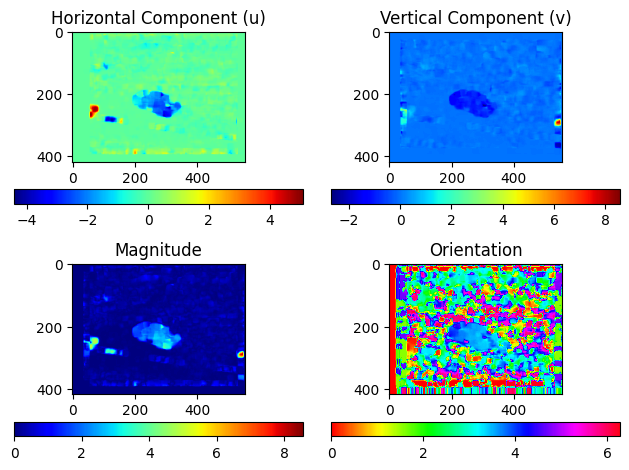

In [35]:
    # Создаем фигуру для отображения данных
fig = plt.figure(tight_layout=True)
gs = GridSpec(2, 2, figure=fig)

   # Подграфик для компоненты u
ax1 = fig.add_subplot(gs[0, 0])
ax1.title.set_text('Horizontal Component (u)')
im1 = ax1.imshow(u, cmap='jet')
fig.colorbar(im1, ax=ax1, orientation='horizontal')

    # Подграфик для компоненты v
ax2 = fig.add_subplot(gs[0, 1])
ax2.title.set_text('Vertical Component (v)')
im2 = ax2.imshow(v, cmap='jet')
fig.colorbar(im2, ax=ax2, orientation='horizontal')

    # Подграфик для магнитуды
ax3 = fig.add_subplot(gs[1, 0])
ax3.title.set_text('Magnitude')
im3 = ax3.imshow(magnitude, cmap='jet')
fig.colorbar(im3, ax=ax3, orientation='horizontal')

    # Подграфик для ориентации
ax4 = fig.add_subplot(gs[1, 1])
ax4.title.set_text('Orientation')
im4 = ax4.imshow(angle, cmap='hsv')  # HSV для лучшего представления угла
fig.colorbar(im4, ax=ax4, orientation='horizontal')

plt.show()

#### Write and test a function to display several optic-flow information

Done upper

#### Study the quiver() function

Done uppper

#### Learn about about a commonly used color wheel representation

In [36]:
def flow_to_color(flow):
    hsv = np.zeros((flow.shape[0], flow.shape[1], 3), dtype=np.uint8)
    mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1]) #(flow) из декартовых координат в полярные координаты#
                                   # принимает два массива (x и y компоненты) и преобразует их в
                                   #полярные координаты (магнитуда и угол).
                                   #Другими словами, она преобразует комплексные числа из декартовых координат в полярные координаты.#

    # Нормализация угла и магнитуды для визуализации
    hsv[..., 0] = ang * 180 / np.pi / 2  # из радиан в градусы и сохраняет их в первом канале массива HSV.
                                          # hsv[..., 0] обращаемся к первому каналу в каждом пикселе
    hsv[..., 1] = 255
    hsv[..., 2] = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX)

    color_flow = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
    return color_flow

In [37]:
flow = cv2.calcOpticalFlowFarneback(I1, I2, None, 0.5, 3, 15, 3, 5, 1.2, 0)
color_flow = flow_to_color(flow)

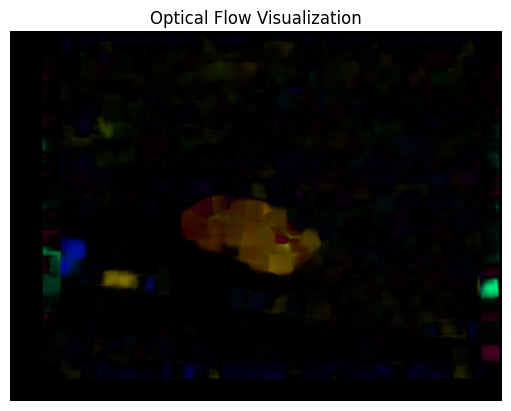

In [38]:
plt.imshow(color_flow)
plt.title('Optical Flow Visualization')
plt.axis('off')
plt.show()

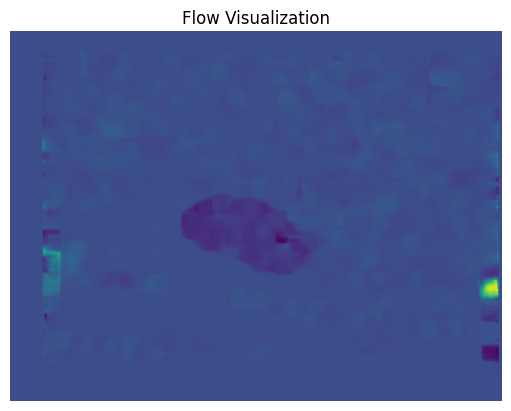

In [39]:
plt.imshow(flow[..., 1]) #array[начало:конец:шаг]
plt.title('Flow Visualization')
plt.axis('off')
plt.show()

#### Implement and experiment with a hierarchical, coarse-to-fine version of LK 16 + 17

In [40]:
def build_pyramid(image, levels):
    pyramid = [image]
    for i in range(levels - 1):
        image = cv2.pyrDown(image)
        pyramid.append(image)
    return pyramid

In [41]:
def coarse_to_fine_lk(frame1, frame2, levels):
    # Построение пирамид
    pyramid1 = build_pyramid(frame1, levels)
    pyramid2 = build_pyramid(frame2, levels)

    # Инициализация потока на самом грубом уровне
    current_flow = np.zeros_like(pyramid1[-1], dtype=np.float32)
    for i in range(levels - 1, -1, -1):
        # Масштабирование потока к текущему уровню
        current_flow = cv2.resize(current_flow, (pyramid1[i].shape[1], pyramid1[i].shape[0]), interpolation=cv2.INTER_LINEAR)

        # Вычисление оптического потока на текущем уровне
        flow = cv2.calcOpticalFlowFarneback(pyramid1[i], pyramid2[i], current_flow, 0.5, 3, 15, 3, 5, 1.2, 0)
        current_flow = flow

    return current_flow

In [42]:
def display_flow(flow):
    # Разделяем компоненты потока
    u = flow[..., 0]
    v = flow[..., 1]
    magnitude, angle = cv2.cartToPolar(flow[..., 0], flow[..., 1])

    # Настройка фигуры для отображения результатов
    fig, axs = plt.subplots(1, 4, figsize=(20, 5))
    fig.suptitle('Optical Flow Components and Magnitude')

    # Отображение горизонтальной компоненты потока
    im0 = axs[0].imshow(u, cmap='coolwarm')
    axs[0].set_title('Horizontal Component (u)')
    fig.colorbar(im0, ax=axs[0])

    # Отображение вертикальной компоненты потока
    im1 = axs[1].imshow(v, cmap='coolwarm')
    axs[1].set_title('Vertical Component (v)')
    fig.colorbar(im1, ax=axs[1])

    # Отображение магнитуды потока
    im2 = axs[2].imshow(magnitude, cmap='hot')
    axs[2].set_title('Flow Magnitude')
    fig.colorbar(im2, ax=axs[2])

    # Отображение направления потока
    im3 = axs[3].imshow(angle, cmap='jet')  # Использование цветовой карты HSV для направления
    axs[3].set_title('Flow Direction')
    fig.colorbar(im3, ax=axs[3])

    plt.show()

In [ ]:
# Загрузка изображений
#frame1 = cv2.imread('frame1.png', cv2.IMREAD_GRAYSCALE)
#frame2 = cv2.imread('frame2.png', cv2.IMREAD_GRAYSCALE)

# Вызов функции
#flow = coarse_to_fine_lk(frame1, frame2, 3)  # 3 уровня пирамиды

In [43]:
# Вызов функции
flow = coarse_to_fine_lk(I1, I2, 3)  # 3 уровня пирамиды

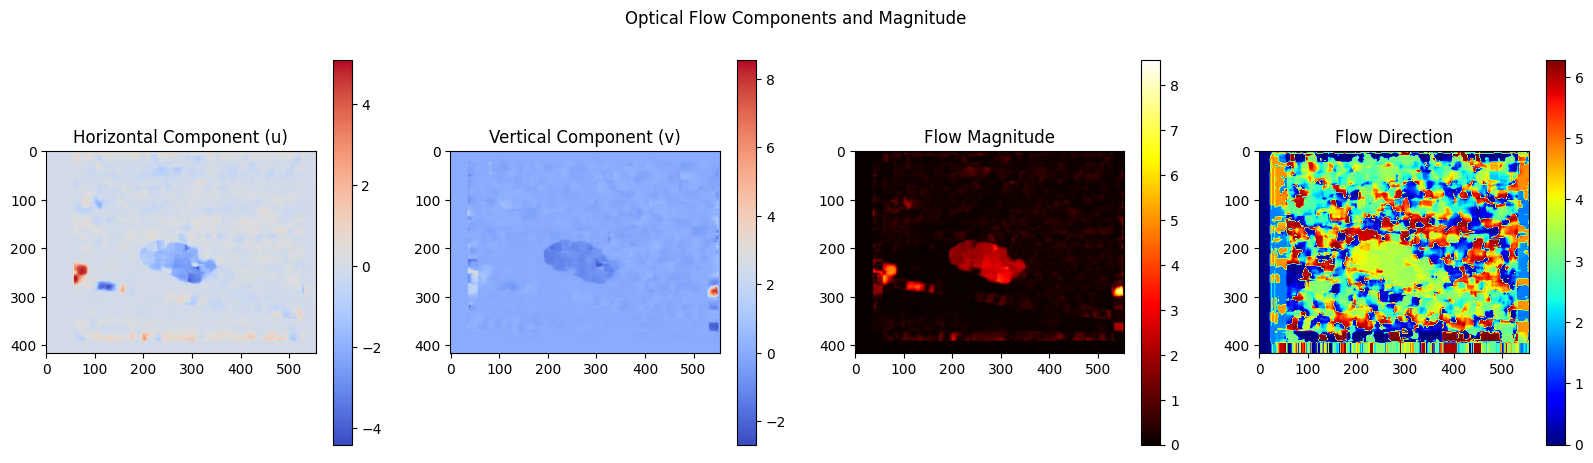

In [44]:
display_flow(flow)

#### Consider one of the full real sequences

In [46]:
import cv2
import os

# Папка с кадрами
frame_folder = './Lab6/imgs-P6/taxi'

# Получаем список имен файлов в папке
file_names = os.listdir(frame_folder)

# Сортируем имена файлов по алфавиту
file_names = sorted(file_names)

# Список кадров
#frames = [os.path.join(frame_folder, frame) for frame in sorted_file_names]
frames = [os.path.join(frame_folder, frame) for frame in sorted(os.listdir(frame_folder)) if frame.lower().endswith('.png')]

# Загружаем первый кадр, чтобы получить его размеры
first_frame = cv2.imread(frames[0])
height, width, _ = first_frame.shape

# Создаем объект VideoWriter
fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Формат видео
#video = cv2.VideoWriter('video.mp4', fourcc, 25.0, (width, height))  # Название файла, кодек, FPS, размер кадра
video = cv2.VideoWriter('./Lab6/imgs-P6/taxi/video.mp4', fourcc, 5.0, (width, height))


# Записываем каждый кадр в видео
for frame in frames:
    image = cv2.imread(frame)
    video.write(image)

# Закрываем объект VideoWriter
video.release()

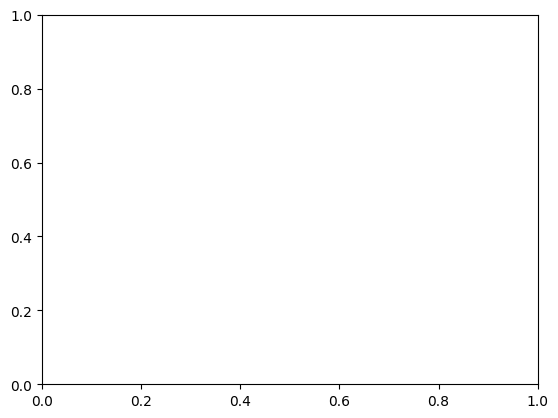

In [47]:
#------Jupyter No Worck in Colab -----
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# Open the video
cap = cv2.VideoCapture('./Lab6/imgs-P6/taxi/video.mp4')
ret, frame1 = cap.read()
if ret:
    frame1 = cv2.cvtColor(frame1, cv2.COLOR_BGR2GRAY)
else:
    print("Failed to load video.")
    cap.release()
    exit()

fig, ax = plt.subplots()

def update(frame_num):
    global frame1
    ret, frame2 = cap.read()
    if not ret:
        print("End of video stream or error.")
        ani.event_source.stop()  # Stop the animation
        return None

    frame2_gray = cv2.cvtColor(frame2, cv2.COLOR_BGR2GRAY)
    flow = cv2.calcOpticalFlowFarneback(frame1, frame2_gray, None, 0.5, 3, 15, 3, 5, 1.2, 0)
    mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])
    frame1 = frame2_gray

    ax.clear()
    ax.imshow(mag, cmap='hot')
    ax.set_title("Optical Flow Magnitude")
    return ax

# Ensure the animation is kept alive by storing it in a variable that remains in scope
ani = FuncAnimation(fig, update, frames=lambda: iter(int, 1), interval=50, cache_frame_data=False)

plt.show()  # This must be called to actually show the animation

# Release video capture
cap.release()

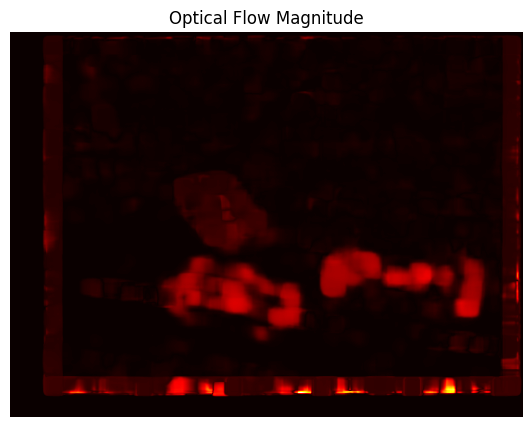

In [48]:
from IPython.display import display, clear_output
import cv2
import numpy as np
import matplotlib.pyplot as plt
import time

cap = cv2.VideoCapture('./Lab6/imgs-P6/taxi/video.mp4')
ret, frame1 = cap.read()
frame1 = cv2.cvtColor(frame1, cv2.COLOR_BGR2GRAY)

try:
    while cap.isOpened():
        ret, frame2 = cap.read()
        if not ret:
            break

        frame2_gray = cv2.cvtColor(frame2, cv2.COLOR_BGR2GRAY)
        flow = cv2.calcOpticalFlowFarneback(frame1, frame2_gray, None, 0.5, 3, 15, 3, 5, 1.2, 0)
        mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])

        frame1 = frame2_gray  # Update previous frame

        plt.figure(figsize=(10, 5))
        plt.imshow(mag, cmap='hot')
        plt.title("Optical Flow Magnitude")
        plt.axis('off')
        display(plt.gcf())
        clear_output(wait=True)
        plt.close()

        time.sleep(0.1)  # Control the speed of the animation

finally:
    cap.release()

In [49]:
import cv2
import numpy as np
from IPython.display import HTML
from base64 import b64encode

# Open video
cap = cv2.VideoCapture('./Lab6/imgs-P6/taxi/video.mp4')
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter('./Lab6/imgs-P6/taxi/output.mp4', fourcc, 5.0, (int(cap.get(3)), int(cap.get(4))))

ret, frame1 = cap.read()
frame1 = cv2.cvtColor(frame1, cv2.COLOR_BGR2GRAY)

while cap.isOpened():
    ret, frame2 = cap.read()
    if not ret:
        break

    frame2_gray = cv2.cvtColor(frame2, cv2.COLOR_BGR2GRAY)
    flow = cv2.calcOpticalFlowFarneback(frame1, frame2_gray, None, 0.5, 3, 15, 3, 5, 1.2, 0)
    mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])

    frame1 = frame2_gray  # Update previous frame

    norm_mag = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    color_mag = cv2.applyColorMap(norm_mag, cv2.COLORMAP_HOT)
    out.write(color_mag)  # Write frame to output video

cap.release()
out.release()


In [50]:
from IPython.display import Video
video_path = './Lab6/imgs-P6/taxi/output.mp4'
Video(video_path)

In [61]:
from IPython.display import HTML
from base64 import b64encode
import base64

In [62]:
mp4 = open('./Lab6/imgs-P6/taxi/output.mp4','rb').read()

In [63]:
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()


In [64]:
HTML("""
<video width=400 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

In [55]:
import moviepy.editor
moviepy.editor.ipython_display('./Lab6/imgs-P6/taxi/video.mp4')

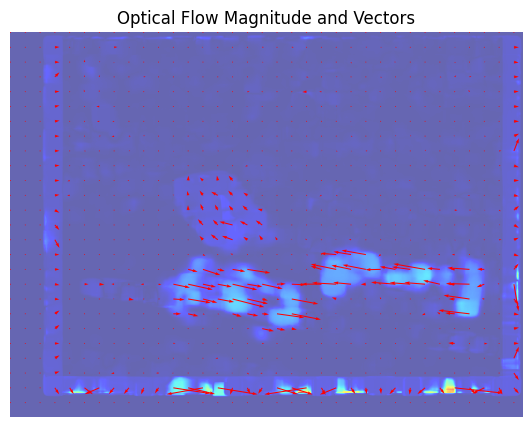

In [68]:
from IPython.display import display, clear_output
import cv2
import numpy as np
import matplotlib.pyplot as plt
import time

cap = cv2.VideoCapture('./Lab6/imgs-P6/taxi/video.mp4')
ret, frame1 = cap.read()
frame1 = cv2.cvtColor(frame1, cv2.COLOR_BGR2GRAY)

try:
    while cap.isOpened():
        ret, frame2 = cap.read()
        if not ret:
            break

        frame2_gray = cv2.cvtColor(frame2, cv2.COLOR_BGR2GRAY)
        flow = cv2.calcOpticalFlowFarneback(frame1, frame2_gray, None, 0.5, 3, 15, 3, 5, 1.2, 0)
        mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])

        frame1 = frame2_gray  # Update previous frame

        # Подготовка данных для quiver
        step = 16  # Шаг сетки для стрелок, уменьшите для более плотного поля стрелок
        x, y = np.meshgrid(np.arange(0, mag.shape[1], step), np.arange(0, mag.shape[0], step))
        u, v = flow[..., 0], flow[..., 1]
        u = u[::step, ::step]
        v = v[::step, ::step]

        plt.figure(figsize=(10, 5))
        plt.imshow(mag, cmap='jet', alpha=0.6)  # Добавление прозрачности для лучшего видения стрелок
        plt.quiver(x, y, u*5, v*5, color='red', angles='xy', scale_units='xy', scale=1, width=0.002, headwidth=3, headlength=5)
        plt.title("Optical Flow Magnitude and Vectors")
        plt.axis('off')
        display(plt.gcf())
        clear_output(wait=True)
        plt.close()

        time.sleep(0.1)  # Control the speed of the animation

finally:
    cap.release()


####  Study some other well-known and good optic flow method. 19 + 20

- 1. FlowNet и FlowNet 2.0
- 2. PWC-Net
- 3. RAFT (Recurrent All-Pairs Field Transforms)
- 4. LiteFlowNet
- 5. MaskFlownet
- For Colab
- 1. RAFT (Recurrent All-Pairs Field Transforms)
- 2. PWC-Net
- 3. LiteFlowNet


##### - FlowNet 2.0 ---  Not FineTune in Colab MUST SWITCH TO PURE GPU Modif Conf in Cafe

In [ ]:
import torch
import cv2
import numpy as np


In [ ]:
!git clone https://github.com/lmb-freiburg/flownet2.git
#%cd flownet2

Cloning into 'flownet2'...
remote: Enumerating objects: 912, done.
remote: Total 912 (delta 0), reused 0 (delta 0), pack-reused 912
Receiving objects: 100% (912/912), 15.98 MiB | 14.37 MiB/s, done.
Resolving deltas: 100% (267/267), done.


In [ ]:
#!pip install -r requirements.txt

In [ ]:
#!python setup.py install

python3: can't open file '/content/flownet2/setup.py': [Errno 2] No such file or directory


In [ ]:
#!wget https://example.com/flownet2-weights.pth

--2024-04-28 18:48:18--  https://example.com/flownet2-weights.pth
Resolving example.com (example.com)... 93.184.215.14, 2606:2800:21f:cb07:6820:80da:af6b:8b2c
Connecting to example.com (example.com)|93.184.215.14|:443... connected.
HTTP request sent, awaiting response... 500 Internal Server Error
2024-04-28 18:48:18 ERROR 500: Internal Server Error.



In [ ]:
#!python scripts/download_weights.py

python3: can't open file '/content/flownet2/scripts/download_weights.py': [Errno 2] No such file or directory


In [ ]:
!chmod +x flownet2/models/download-models.sh  # Make the script executable
!flownet2/models/download-models.sh  # Run the script to download model files


--2024-04-29 14:16:24--  https://lmb.informatik.uni-freiburg.de/resources/binaries/flownet2/flownet2-models.tar.gz
Resolving lmb.informatik.uni-freiburg.de (lmb.informatik.uni-freiburg.de)... 132.230.167.23
Connecting to lmb.informatik.uni-freiburg.de (lmb.informatik.uni-freiburg.de)|132.230.167.23|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2470481192 (2.3G) [application/x-gzip]
Saving to: ‘flownet2-models.tar.gz.1’

flownet2-models.tar 100%[===================>]   2.30G  8.77MB/s    in 14m 4s  

2024-04-29 14:30:30 (2.79 MB/s) - ‘flownet2-models.tar.gz.1’ saved [2470481192/2470481192]

FlowNet2/
FlowNet2/FlowNet2_deploy.prototxt.template
FlowNet2/FlowNet2_weights.caffemodel.h5

gzip: stdin: unexpected end of file
tar: Unexpected EOF in archive
tar: Unexpected EOF in archive
tar: Error is not recoverable: exiting now


In [ ]:
import os
print(os.listdir())

['.config', 'flownet2-models.tar.gz.1', 'FlowNet2', 'flownet2', 'flownet2-models.tar.gz', 'sample_data']


In [ ]:
!apt update
!apt install -y build-essential cmake git
!apt install -y libprotobuf-dev libleveldb-dev libsnappy-dev libopencv-dev libhdf5-serial-dev protobuf-compiler
!apt install -y --no-install-recommends libboost-all-dev
!apt install -y libatlas-base-dev
!apt install -y libgflags-dev libgoogle-glog-dev liblmdb-dev

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Get:3 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ Packages [52.9 kB]
Get:4 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Hit:5 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Hit:7 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Get:8 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [1,756 kB]
Get:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease [18.1 kB]
Get:10 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [109 kB]
Get:11 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease [24.3 kB]
Hit:12 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:13 http://security.ubuntu.com/ub

In [ ]:
!git clone https://github.com/BVLC/caffe.git
%cd caffe
!cp Makefile.config.example Makefile.config

Cloning into 'caffe'...
remote: Enumerating objects: 65274, done.
remote: Total 65274 (delta 0), reused 0 (delta 0), pack-reused 65274
Receiving objects: 100% (65274/65274), 74.14 MiB | 14.87 MiB/s, done.
Resolving deltas: 100% (41242/41242), done.
/content/caffe


In [ ]:
#!make all -j$(nproc)
#!make test -j$(nproc)
#!make run

In [ ]:
!sed -i 's/# USE_CUDNN := 1/USE_CUDNN := 1/' Makefile.config
!sed -i 's/# OPENCV_VERSION := 3/OPENCV_VERSION := 3/' Makefile.config
!sed -i 's/# WITH_PYTHON_LAYER := 1/WITH_PYTHON_LAYER := 1/' Makefile.config
!make all -j$(nproc)
!make test -j$(nproc)
!make runtest -j$(nproc)
!make pycaffe -j$(nproc)


PROTOC src/caffe/proto/caffe.proto
NVCC src/caffe/layers/clip_layer.cu
nvcc fatal   : Unsupported gpu architecture 'compute_20'
make: *** [Makefile:605: .build_release/cuda/src/caffe/layers/clip_layer.o] Error 1
make: *** Waiting for unfinished jobs....
CXX src/caffe/test/test_layer_factory.cpp
CXX src/caffe/test/test_convolution_layer.cpp
In file included from ./include/caffe/util/device_alternate.hpp:40,
                 from ./include/caffe/common.hpp:19,
                 from src/caffe/test/test_layer_factory.cpp:7:
./include/caffe/util/cudnn.hpp: In function ‘const char* cudnnGetErrorString(cudnnStatus_t)’:
./include/caffe/util/cudnn.hpp:21:10: warning: enumeration value ‘CUDNN_STATUS_VERSION_MISMATCH’ not handled in switch [-Wswitch]
   21 |   switch (status) {
      |          ^
CXX src/caffe/test/test_flatten_layer.cpp
In file included from ./include/caffe/util/device_alternate.hpp:40,
                 from ./include/caffe/common.hpp:19,
                 from ./include/caffe/bl

In [ ]:
import torch
print(torch.backends.cudnn.version())


8906


In [ ]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0


In [ ]:
#!make clean
#!make all -j$(nproc)

PROTOC src/caffe/proto/caffe.proto
NVCC src/caffe/layers/relu_layer.cu
nvcc fatal   : Unsupported gpu architecture 'compute_20'
make: *** [Makefile:605: .build_release/cuda/src/caffe/layers/relu_layer.o] Error 1
make: *** Waiting for unfinished jobs....


In [ ]:
#import sys
#caffe_root = './'  # Путь к папке Caffe
#sys.path.insert(0, caffe_root + 'python')
#import caffe

In [ ]:
import caffe

In [ ]:
ls

build@          CONTRIBUTING.md  docker/    INSTALL.md       Makefile.config.example  README.md
caffe.cloc      CONTRIBUTORS.md  docs/      LICENSE          matlab/                  scripts/
cmake/          data/            examples/  Makefile         models/                  src/
CMakeLists.txt  distribute/      include/   Makefile.config  python/                  tools/


In [ ]:
!python -c "import caffe; print('Caffe успешно установлен!')"

Traceback (most recent call last):
  File "<string>", line 1, in <module>
ModuleNotFoundError: No module named 'caffe'


In [ ]:
#net = caffe.Net('FlowNet2_deploy.prototxt', 'FlowNet2_weights.caffemodel.h5', caffe.TEST)

##### RAFT (Recurrent All-Pairs Field Transforms)


In [ ]:
# Установка необходимых библиотек
#!pip install torch torchvision

In [ ]:
#!rm -rf '/content/data'
#!rm -rf '/content/RAFT'

shell-init: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory
shell-init: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory


In [1]:
# Импорт библиотек
import torch
import torchvision.transforms as T
from PIL import Image
import requests
from io import BytesIO

In [2]:
# Функция для загрузки и предобработки изображений
def load_and_preprocess_image(url):
    response = requests.get(url)
    image = Image.open(BytesIO(response.content)).convert('RGB')
    transform = T.Compose([
        T.ToTensor(),  # Преобразование в тензор PyTorch
        T.Resize((720, 1280)),  # Изменение размера для соответствия входу модели
        T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Нормализация
    ])
    image = transform(image)[None]  # Добавление размерности пакета
    return image

In [3]:
#!mkdir RAFT
!git clone https://github.com/princeton-vl/RAFT.git
%cd RAFT
#!pip install -r requirements.txt


Cloning into 'RAFT'...
remote: Enumerating objects: 147, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 147 (delta 0), reused 2 (delta 0), pack-reused 144
Receiving objects: 100% (147/147), 10.01 MiB | 9.06 MiB/s, done.
Resolving deltas: 100% (57/57), done.
/content/RAFT


In [4]:
!sh download_models.sh

--2024-04-30 08:28:56--  https://dl.dropboxusercontent.com/s/4j4z58wuv8o0mfz/models.zip
Resolving dl.dropboxusercontent.com (dl.dropboxusercontent.com)... 162.125.68.15, 2620:100:6023:15::a27d:430f
Connecting to dl.dropboxusercontent.com (dl.dropboxusercontent.com)|162.125.68.15|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 81977417 (78M) [application/zip]
Saving to: ‘models.zip’

models.zip          100%[===================>]  78.18M  20.1MB/s    in 3.9s    

2024-04-30 08:29:01 (19.9 MB/s) - ‘models.zip’ saved [81977417/81977417]

Archive:  models.zip
   creating: models/
  inflating: models/raft-kitti.pth   
  inflating: models/raft-sintel.pth  
  inflating: models/raft-chairs.pth  
  inflating: models/raft-things.pth  
  inflating: models/raft-small.pth   


In [5]:
ls

alt_cuda_corr/    demo-frames/         evaluate.py  models.zip  train_mixed.sh*
chairs_split.txt  demo.py              LICENSE      RAFT.png    train.py
core/             download_models.sh*  models/      README.md   train_standard.sh*


In [6]:
import RAFT
help(RAFT)  # или print(dir(raft))


Help on package RAFT:

NAME
    RAFT

PACKAGE CONTENTS
    core (package)
    demo
    evaluate
    train

FILE
    (built-in)




In [7]:
import RAFT.core
help(RAFT.core)  # Это покажет вам доступные модули и классы в подпакете core

Help on package RAFT.core in RAFT:

NAME
    RAFT.core

PACKAGE CONTENTS
    corr
    datasets
    extractor
    raft
    update
    utils (package)

FILE
    /content/RAFT/core/__init__.py




In [8]:
from RAFT.core import utils as raft_utils
help(raft_utils)  # Надеемся найти тут класс модели

Help on package RAFT.core.utils in RAFT.core:

NAME
    RAFT.core.utils

PACKAGE CONTENTS
    augmentor
    flow_viz
    frame_utils
    utils

FILE
    /content/RAFT/core/utils/__init__.py




In [ ]:
#import matplotlib.pyplot as plt
#import numpy as np
##RAFT/demo.py shoul be corrected for GoogleColab
#def viz(img, flo, nimg):
#    img = img[0].permute(1, 2, 0).cpu().numpy()
#    flo = flo[0].permute(1, 2, 0).cpu().numpy()
#
#    # Map flow to RGB image
#    flo = flow_viz.flow_to_image(flo)
#    img_flo = np.concatenate([img, flo], axis=0)

#    # Create output directory if it doesn't exist
#    output_dir = "img-Out"
#    os.makedirs(output_dir, exist_ok=True)

#    # Display using matplotlib
#    plt.imshow(img_flo / 255.0)
#    plt.show()

#    # Save to file using OpenCV
#    output_path = os.path.join(output_dir, nimg.split('.')[0] + "_result.png")
#    cv2.imwrite(output_path, cv2.cvtColor((img_flo * 255).astype(np.uint8), cv2.COLOR_RGB2BGR))


##-------------------- AND CORRECT IN def demo(args):
#
#            filename = os.path.basename(imfile1)
#            flow_low, flow_up = model(image1, image2, iters=20, test_mode=True)
#            viz(image1, flow_up, filename)

In [10]:
!python demo.py --model=models/raft-things.pth --path=demo-frames



/usr/local/lib/python3.10/dist-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3549.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Figure(640x480)
Figure(640x480)
Figure(640x480)
Figure(640x480)
Figure(640x480)
Figure(640x480)
Figure(640x480)
Figure(640x480)
Figure(640x480)


In [16]:
import requests
import zipfile
import io
import os

# Загрузка zip-архива по ссылке
url = 'https://vision.middlebury.edu/flow/data/comp/zip/other-color-allframes.zip'  # Замените ссылку на нужную
response = requests.get(url)

# Разархивация
with zipfile.ZipFile(io.BytesIO(response.content), 'r') as zip_ref:
    zip_ref.extractall('/content/data')  # Путь, куда будет извлечено содержимое

# Проверка результатов
print(os.listdir('/content/data'))  # Показать содержимое директории после разархивации

['other-data']


In [17]:
!python demo.py --model=models/raft-things.pth --path="/content/data/other-data/Beanbags"

/usr/local/lib/python3.10/dist-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3549.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Figure(640x480)
Figure(640x480)
Figure(640x480)
Figure(640x480)
Figure(640x480)
Figure(640x480)
Figure(640x480)


In [19]:
import os
import cv2
# Путь для сохранения видео
output_video_path = "./img-Out/output.mp4"
# Путь к папке с изображениями
image_folder = "./img-Out"

In [20]:
image_folder

'./img-Out'

In [14]:
def create_video_from_images(output_path, image_folder):
    # Получаем список всех изображений в папке
    images = [img for img in os.listdir(image_folder) if img.endswith(".png")]

    # Сортируем изображения по именам
    images.sort()

    # Получаем размеры первого изображения, чтобы создать видео с теми же размерами
    frame = cv2.imread(os.path.join(image_folder, images[0]))
    height, width, layers = frame.shape

    # Создаем объект VideoWriter для сохранения видео
    video = cv2.VideoWriter(output_path, cv2.VideoWriter_fourcc(*'mp4v'), 30, (width,height))

    # Добавляем изображения в видео
    for image in images:
        video.write(cv2.imread(os.path.join(image_folder, image)))

    # Закрываем объект VideoWriter
    cv2.destroyAllWindows()
    video.release()

In [21]:
# Создаем видео из изображений
create_video_from_images(output_video_path, image_folder)

In [ ]:
#from PIL import Image

#def resize_and_save_images(input_folder, output_folder):
    # Создание выходной папки, если она не существует
#    os.makedirs(output_folder, exist_ok=True)

#    # Получение списка файлов формата png во входной папке и сортировка по алфавиту
#    png_images = [img for img in os.listdir(input_folder) if img.endswith(".png")]
#    png_images.sort()

#    # Проход по каждому изображению
#    for img_name in png_images:
#        # Полный путь к исходному изображению
#        input_path = os.path.join(input_folder, img_name)

#        # Открытие изображения
#        img = Image.open(input_path)
#
        # Изменение размера, dpi и глубины цвета
#        img_resized = img.resize((1024, 436)).convert('RGB').convert('RGB', palette=Image.ADAPTIVE, colors=256)
#        img_resized.save(os.path.join(output_folder, img_name), dpi=(96, 96), quality=95)

## Пример использования
#input_folder = "/content/Lab6/imgs-P6/taxi/"
#output_folder = "/content/Lab6/imgs-P6/taxiRAFT/"
#resize_and_save_images(input_folder, output_folder)